# Processing AWS Comprehend Output Files

This code converts output of AWS Comprehend (JSON files) into dataframes. Dataframes can be analyzed in python or outputted into CSV file for analysis elsewhere. 
The code covers three types of outputs:
1. Key Phrases
2. Entities
3. Sentiment

There are generally 2 issues with Amazon Comprehend JSON parsing: 1) they have multiple lines and 2) they have nested JSON dictionaries. The nested dictionaries are addressed in the code, and their names can be changed if needed. 

In [1]:
import pandas as pd
import json
import numpy as np

## 1. Key Phrases 

In [2]:
input_file = 'Comprehend\\outputs\\key_phrases_output.json'

# Read JSON into a dictionary   
key_phrases = [json.loads(line) for line in open(input_file, 'r')]
len(key_phrases)

3

In [3]:
def parse_key_phrases(data):
    df = pd.DataFrame() # declare an empty dataframe
    nested_json = 'KeyPhrases' # nested sub-dictiptionary to extract data from
    for line in data:
        dt_temp = pd.DataFrame(line[nested_json])  # extract data from sub-dictionary
        other_fields = list(line.keys())
        other_fields.remove(nested_json) # remove nested fields
        for field in other_fields: 
            dt_temp[field] = line[field]
        
        df = df.append(dt_temp, ignore_index = True)
        
    return(df)

In [4]:
# Parse the data
key_phrases_df = parse_key_phrases(key_phrases)
key_phrases_df.head()

,BeginOffset,EndOffset,Score,Text,File
0,19,28,0.999987,for a spy,amazon_tweets_5000.csv
1,38,57,0.942875,up labor organizing,amazon_tweets_5000.csv
2,75,83,0.999999,for this,amazon_tweets_5000.csv
3,125,152,0.611420,you https://t.co/Pya0UOKINY,amazon_tweets_5000.csv
4,154,164,0.783439,"""US Amazon",amazon_tweets_5000.csv


## 2. Entities

In [5]:
input_file = 'Comprehend\\outputs\\stores_entities.json'

# Read JSON into a dictionary   
entities = [json.loads(line) for line in open(input_file, 'r')]
len(entities)

62689

In [6]:
# This function parses entities data into a dataframe
def parse_entities(data):
    df = pd.DataFrame() # declare an empty dataframe
    nested_json = 'Entities' # nested sub-dictiptionary to extract data from
    # populate the dataframe
    for line in data:
        dt_temp = pd.DataFrame(line[nested_json])  # extract data from sub-dictionary
        other_fields = list(line.keys())
        other_fields.remove(nested_json) # remove nested fields        
        for field in other_fields:  # add common fields
            dt_temp[field] = line[field]
        
        df = df.append(dt_temp, ignore_index = True)
        
    return(df)

In [7]:
# Produce the dataframe
entities_df = parse_entities(entities)
entities_df.head()

,BeginOffset,EndOffset,Score,Text,Type,File,Line
0,1.0,7.0,0.998351,Amazon,ORGANIZATION,amazon_tweets.csv,0
1,128.0,151.0,0.996499,https://t.co/Pya0UOKINY,OTHER,amazon_tweets.csv,0
2,1.0,3.0,0.716759,US,ORGANIZATION,amazon_tweets.csv,1
3,4.0,10.0,0.926377,Amazon,ORGANIZATION,amazon_tweets.csv,1
4,1.0,2.0,0.533937,1,QUANTITY,amazon_tweets.csv,3


## 3. Sentiment

In [8]:
input_file = 'Comprehend\\outputs\\sentiment2.json'

# Read JSON into a dictionary   
sentiment = [json.loads(line) for line in open(input_file, 'r')]
len(sentiment)

29287

In [9]:
# This function parses sentiment data into a dataframe
def parse_sentiment(data):
    df = pd.DataFrame() 
    for line in data:
        try:
            dt_temp = pd.DataFrame(line['SentimentScore'], index = [0])  # extract data from sub-dictionary
            for field in list(line.keys())[:-1]:  # add common fields
                dt_temp[field] = line[field]
        
            df = df.append(dt_temp, ignore_index = True)
                  
        except:
            for field in list(line.keys())[:-1]:  # add common fields
                dt_temp[field] = line[field]
        
            df = df.append(dt_temp, ignore_index = True)
    
    return(df)

In [10]:
# Process data!
sentiment_df = parse_sentiment(sentiment)
sentiment_df.head()

,Mixed,Negative,Neutral,Positive,File,Line,Sentiment
0,2.472798e-06,0.000919,0.933964,0.065115,amazon_tweets.csv,6,NEUTRAL
1,4.301400e-03,0.443537,0.445010,0.107152,amazon_tweets.csv,11,NEUTRAL
2,3.433179e-06,0.099203,0.711973,0.188821,amazon_tweets.csv,15,NEUTRAL
3,6.509443e-06,0.719563,0.171055,0.109375,amazon_tweets.csv,26,NEGATIVE
4,6.015364e-07,0.000030,0.998039,0.001931,amazon_tweets.csv,30,NEUTRAL


## Export Data

In [15]:
output_path = 'Comprehend\\outputs\\processed\\'
name = 'stores.csv'

entities_output_name = output_path + 'entities_output_' + name
sentiment_output_name = output_path + 'sentiment_output_' + name
key_phrases_output_name = output_path + 'keyphrases_output_' + name

In [16]:
# Export files
entities_df.to_csv(entities_output_name, index = None)
sentiment_df.to_csv(sentiment_output_name, index = None)
key_phrases_df.to_csv(sentiment_output_name, index = None)

## Create Sentiment Charts

In this section, I create some distribution charts for sentiment analysis based on AWS Comprehend output.

In [17]:
import seaborn as sns
import matplotlib as plt

In [18]:
# Prep the data
sentiment_df.File.replace({'amazon_tweets.csv':'Amazon',
                           'walmart_tweets.csv':'Walmart',
                           'kroger_tweets.csv':'Kroger'},
                         inplace = True)
sentiment_df.columns = ['Mixed', 'Negative', 'Neutral', 'Positive', 'Store', 'Line', 'Sentiment'] # File-> Store

### Counts Plot

Tweet count by store brand and sentiment. 

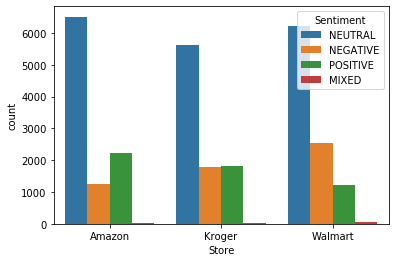

In [19]:
sns.countplot(x = 'Store', hue ='Sentiment' , data = sentiment_df);

### Percent Sentiment Plot

In [20]:
percentage = (sentiment_df.groupby(['Store', 'Sentiment']).size()/sentiment_df.groupby(['Store']).size()).reset_index()
percentage

,Store,Sentiment,0
0,Amazon,MIXED,0.002400
1,Amazon,NEGATIVE,0.124600
2,Amazon,NEUTRAL,0.651100
3,Amazon,POSITIVE,0.221900
4,Kroger,MIXED,0.002800
5,Kroger,NEGATIVE,0.193389
6,Kroger,NEUTRAL,0.606870
7,Kroger,POSITIVE,0.196942
8,Walmart,MIXED,0.004500
9,Walmart,NEGATIVE,0.254200


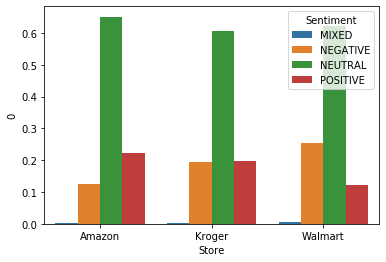

In [21]:
sns.barplot(x = 'Store', hue ='Sentiment', y = 0, data = percentage);

Stacked barplot of sentiment by store brand.

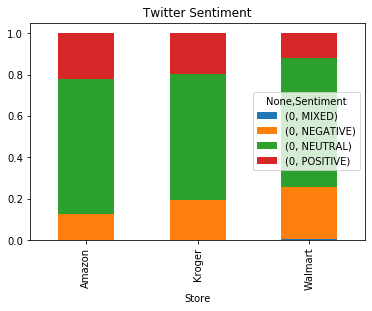

In [22]:
percentage.pivot(index = 'Store', columns = 'Sentiment').plot(kind = 'bar',
                                                              stacked = True,
                                                             title = "Twitter Sentiment");